### 머신러닝 기반 타이어 마모도(Degradation) 회귀 분석

- 분석 목표:
    - C1~C6 컴파운드 타이어만 쓰기 시작한 2023년부터 최근까지의 모든 레이스를 통합 분석
    - 랩타임이 느려지는 드라이 타이어와 트랙이 마르며 빨라지는 웨트 타이어의 상반된 물리적 특성을 데이터로 증명

- 데이터 전처리 (Data Cleansing): 세이프티카(SC), VSC, 피트 인/아웃 랩 등 비정상 주행 데이터를 필터링하고, 스틴트(Stint) 단위로 데이터를 재구조화하여 순수 주행 패턴만 추출.
- 회귀 분석 (Linear Regression): 각 스틴트별로 LapTime ~ TyreAge 선형 회귀 모델을 학습시켜, **'랩당 성능 변화율(Slope)'**을 기울기로 산출.
- 이원화 시각화 (Dual-Scale Visualization): 변동폭이 작은 드라이 타이어와 변동폭이 큰 웨트 타이어의 특성을 동시에 파악하기 위해 Y축 스케일을 분리(Subplots with Independent Scales)하여 시각화 최적화.

In [10]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression

# === [설정] ===
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "f1_analytics_db"
YEARS = range(2023, 2026) # 2023년 이후 데이터 전수 조사

def get_all_tyre_data():
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]

    stint_data = []
    print(f"🏎️ 2023-2025 전체 타이어 데이터 분석 시작 (Wet/Inter 포함)...")

    for year in YEARS:
        # 레이스 스케줄 조회
        races = list(db.races_meta.find({"Year": year, "SessionType": "Race"}))
        print(f"   📅 {year}년 데이터 스캔 중 ({len(races)}개 경기)...")

        for race in races:
            # 랩 데이터 가져오기 (SC/VSC 제외한 정상 랩만)
            laps = list(db.laps.find({
                "Year": year, "Round": race['Round'], "SessionType": "Race",
                "IsAccurate": True
            }))
            df = pd.DataFrame(laps)

            if df.empty: continue

            # 필요한 컬럼만 선택
            df = df[['Driver', 'LapNumber', 'LapTime_Sec', 'Compound', 'TyreLife']]

            # 드라이버별 스틴트 분석
            for driver in df['Driver'].unique():
                drv_df = df[df['Driver'] == driver].sort_values("LapNumber")

                # 스틴트 구분 (수명 리셋 or 타이어 변경 감지)
                drv_df['Stint_Change'] = (drv_df['TyreLife'].diff().fillna(0) < 0) | (drv_df['Compound'] != drv_df['Compound'].shift(1))
                drv_df['Stint_ID'] = drv_df['Stint_Change'].cumsum()

                for s_id in drv_df['Stint_ID'].unique():
                    stint = drv_df[drv_df['Stint_ID'] == s_id].copy()
                    stint = stint.dropna(subset=['TyreLife', 'LapTime_Sec'])

                    # 최소 5랩 이상 주행한 유의미한 데이터만 분석
                    if len(stint) < 5: continue

                    compound = stint['Compound'].iloc[0]
                    if compound not in ['SOFT', 'MEDIUM', 'HARD', 'INTERMEDIATE', 'WET']: continue

                    # 회귀 분석 (기울기 = 마모도 추출)
                    X = stint[['TyreLife']].values.reshape(-1, 1)
                    y = stint['LapTime_Sec'].values

                    try:
                        model = LinearRegression()
                        model.fit(X, y)
                        slope = model.coef_[0]

                        # 이상치 제거 (웨트 타이어는 변동폭이 커서 범위 넓게 설정)
                        if -3.0 < slope < 3.0:
                            stint_data.append({
                                "Year": year,
                                "Circuit": race['Circuit'],
                                "Compound": compound,
                                "Degradation": slope, # 초/랩 (양수: 느려짐, 음수: 빨라짐)
                                "Laps": len(stint)
                            })
                    except: continue

    print(f"✅ 분석 완료: 총 {len(stint_data)}개의 스틴트 데이터 확보.")
    return pd.DataFrame(stint_data)

def visualize_separated_compounds(df):
    if df.empty:
        print("⚠️ 시각화할 데이터가 없습니다.")
        return

    print("🎨 타이어 특성 분리 시각화 생성 중...")

    # 데이터 분리 (Dry vs Wet)
    dry_compounds = ['SOFT', 'MEDIUM', 'HARD']
    wet_compounds = ['INTERMEDIATE', 'WET']

    df_dry = df[df['Compound'].isin(dry_compounds)]
    df_wet = df[df['Compound'].isin(wet_compounds)]

    # 타이어 색상 맵 (Pirelli 공식)
    color_map = {
        "SOFT": "#FF3333", "MEDIUM": "#F2C910", "HARD": "#CCCCCC",
        "INTERMEDIATE": "#38B023", "WET": "#2D66B4"
    }

    # 서브플롯 생성 (1행 2열)
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("🏎️ 드라이 타이어 (마모 집중)", "🌧️ 웨트 타이어 (트랙 진화 집중)"),
        horizontal_spacing=0.1
    )

    # === [Left] Dry Tires (Box Plot) ===
    for comp in dry_compounds:
        comp_data = df_dry[df_dry['Compound'] == comp]
        fig.add_trace(go.Box(
            y=comp_data['Degradation'],
            name=comp,
            marker=dict(color=color_map[comp]),
            boxpoints='outliers', # 이상치만 점으로 표시 (깔끔하게)
            jitter=0.3
        ), row=1, col=1)

    # === [Right] Wet Tires (Box Plot) ===
    for comp in wet_compounds:
        comp_data = df_wet[df_wet['Compound'] == comp]
        fig.add_trace(go.Box(
            y=comp_data['Degradation'],
            name=comp,
            marker=dict(color=color_map[comp]),
            boxpoints='outliers',
            jitter=0.3
        ), row=1, col=2)

    # === 레이아웃 및 축 설정 (핵심!) ===
    fig.update_layout(
        title="📊 F1 타이어 특성 심층 분석: 마모(Wear) vs 진화(Evolution)",
        template="plotly_dark",
        height=600,
        showlegend=False # 이름이 축에 나오므로 범례 숨김
    )

    # [왼쪽 Y축] 드라이 타이어용 (확대)
    # 보통 마모도는 -0.1 ~ 0.5 사이에 집중됨 -> 이 구간을 집중해서 보여줌
    fig.update_yaxes(
        title_text="Degradation (s/lap)",
        range=[-0.1, 0.5], # 여기가 핵심: 범위를 좁혀서 박스를 크게 만듦
        row=1, col=1,
        zeroline=True, zerolinewidth=2, zerolinecolor='white'
    )

    # [오른쪽 Y축] 웨트 타이어용 (전체 범위)
    # 트랙 에볼루션 때문에 -3.0까지 내려갈 수 있음 -> 넓게 보여줌
    fig.update_yaxes(
        title_text="Degradation (s/lap)",
        # range는 자동(Auto)으로 두거나 넓게 잡음
        row=1, col=2,
        zeroline=True, zerolinewidth=2, zerolinecolor='white'
    )

    # 설명 주석 추가
    fig.add_annotation(
        x=1, y=0.45, text="Degradation (마모)",
        showarrow=False, font=dict(color="red", size=12), row=1, col=1
    )
    fig.add_annotation(
        x=0.5, y=-1.5, text="Track Evolution (기록 단축)",
        showarrow=False, font=dict(color="#00D2BE", size=12), row=1, col=2
    )

    fig.show()

if __name__ == "__main__":
    df_all = get_all_tyre_data()
    visualize_separated_compounds(df_all)

🏎️ 2023-2025 전체 타이어 데이터 분석 시작 (Wet/Inter 포함)...
   📅 2023년 데이터 스캔 중 (22개 경기)...
   📅 2024년 데이터 스캔 중 (24개 경기)...
   📅 2025년 데이터 스캔 중 (22개 경기)...
✅ 분석 완료: 총 3148개의 스틴트 데이터 확보.
🎨 타이어 특성 분리 시각화 생성 중...


<img src="https://fueler.store/cdn/shop/articles/explained-pirelli-f1-tyre-compounds-fuelertm_51ea6bd3-3c4a-4b6c-a402-1900cb530319.jpg?v=1759248361" width="400"/>
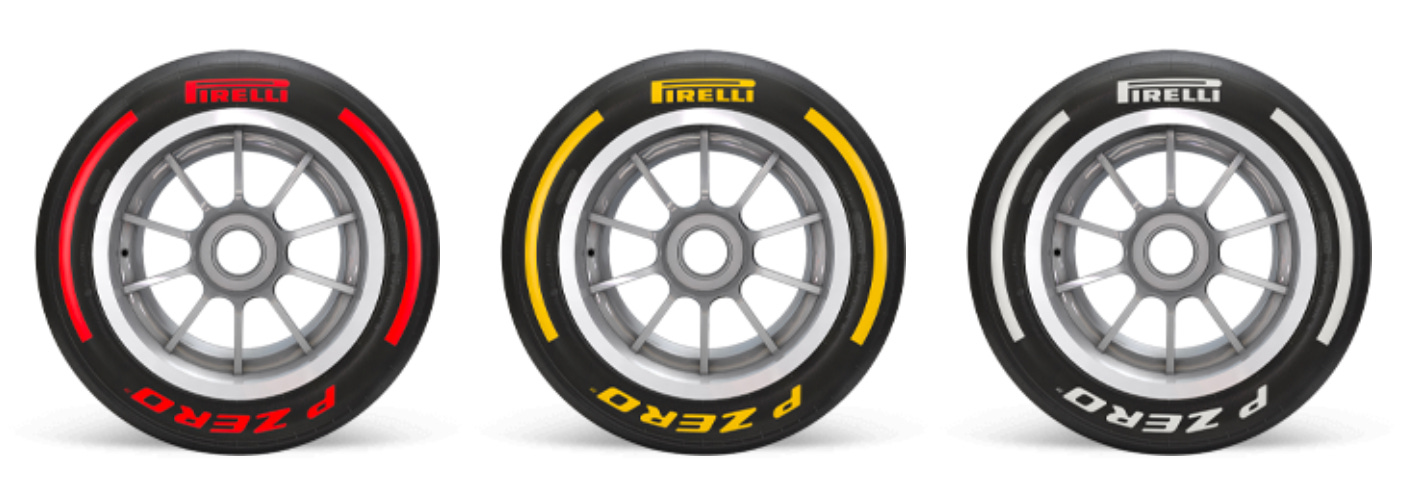
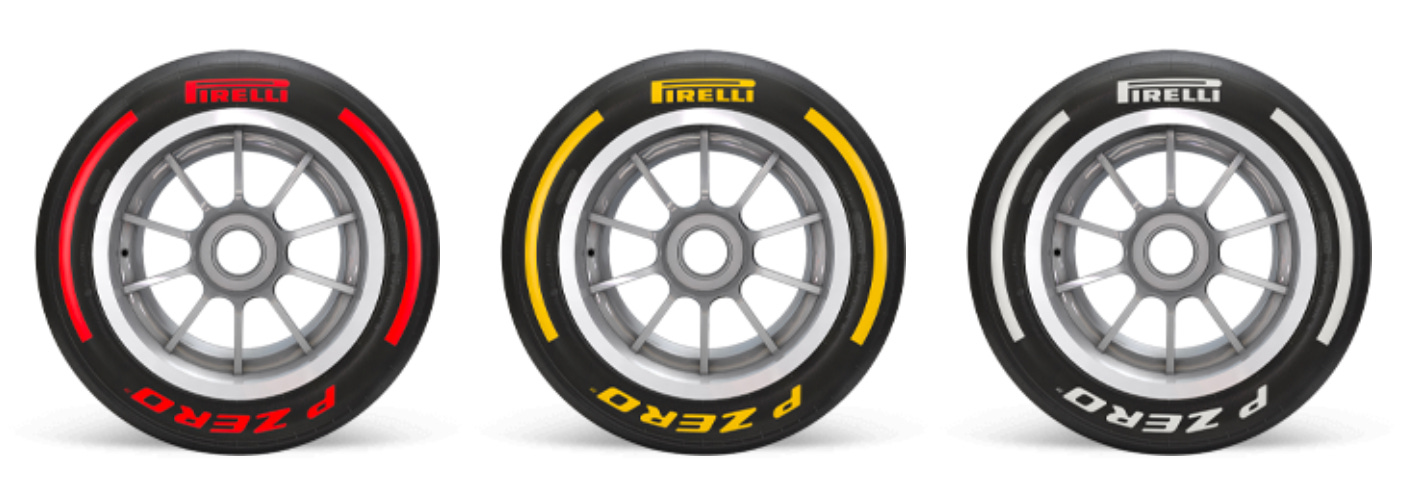

**드라이 타이어와 웨트 타이어의 정반대의 시계열적 특성**
<br/>

- 드라이 타이어 (Soft, Medium, Hard):
    - Soft (빨강):
        - 박스 위치가 가장 높고, 위아래 꼬리가 깁니다.
        - 소프트 타이어는 마모가 가장 빠를 뿐만 아니라, 서킷 특성이나 드라이버의 타이어 관리 능력에 따라 성능 편차(Variance)가 매우 큼을 의미합니다. 전략 수립 시 리스크가 큰 타이어입니다.
    - Hard (회색):
        - 박스가 0점에 가깝게 붙어있고 매우 납작합니다.
        - 하드 타이어는 랩당 0.01~0.03초 수준의 미미한 마모도를 보이며, 매우 높은 내구성으로 레이스 후반부의 안정적인 페이스를 보장합니다.
<br/>

- 웨트 타이어:
    - Wet (파랑) & Intermediate (초록):
        - 박스가 0보다 아래인 음수 영역에 위치합니다.
        - 비가 오는 상황에서는 타이어가 닳아서 느려지는 효과보다, 트랙의 물기가 마르면서 접지력이 살아나는 속도(Track Evolution)가 훨씬 압도적입니다.
        - 웨트 상황에서는 타이어를 아끼는 것보다, 트랙이 마르는 시점까지 버티다가 적절한 타이밍에 타이어를 교체하는 것이 랩타임 단축의 핵심입니다.

### 피트스톱 전략

In [16]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import plotly.express as px
import itertools
from sklearn.linear_model import LinearRegression

# === [설정] ===
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "f1_analytics_db"
YEARS = range(2023, 2026) # 3개년 분석
PIT_LOSS_AVG = 22.0 # 평균 피트 로스

def get_race_parameters(db, year, round_num, total_laps):
    """
    머신러닝(회귀)을 통해 해당 경기의 타이어 물성(기초 페이스, 마모도)을 역산
    """
    laps_cursor = db.laps.find({
        "Year": year, "Round": round_num, "SessionType": "Race",
        "IsAccurate": True
    })
    df = pd.DataFrame(list(laps_cursor))

    if df.empty: return None

    params = {}

    # 각 컴파운드(S, M, H)의 성능 데이터 추출
    for compound in ['SOFT', 'MEDIUM', 'HARD']:
        comp_data = df[df['Compound'] == compound]
        if len(comp_data) < 10: continue

        # 이상치 제거 (IQR)
        q1 = comp_data['LapTime_Sec'].quantile(0.25)
        q3 = comp_data['LapTime_Sec'].quantile(0.75)
        comp_data = comp_data[(comp_data['LapTime_Sec'] >= q1 - 1.5 * (q3-q1)) & (comp_data['LapTime_Sec'] <= q3 + 1.5 * (q3-q1))]

        X = comp_data[['TyreLife']].values.reshape(-1, 1)
        y = comp_data['LapTime_Sec'].values

        try:
            model = LinearRegression()
            model.fit(X, y)
            base_pace = model.intercept_
            deg = model.coef_[0]

            # 정상적인 마모도 범위일 때만 채택 (0 < deg < 0.5)
            if 0 < deg < 0.5:
                params[compound] = {"base_pace": base_pace, "deg": deg}
        except: continue

    if len(params) < 2: return None # 비교할 타이어가 없으면 불가
    return params

def calculate_total_time(strategies, params, total_laps):
    """전략(타이어 순서)에 따른 총 레이스 시간 계산"""
    total_time = 0
    pit_stops = len(strategies) - 1
    stint_len = total_laps / len(strategies) # 균등 분할 가정

    for compound in strategies:
        if compound not in params: return float('inf')
        p = params[compound]
        # 적분 근사: Base*L + Deg * (L^2 / 2)
        time = (p['base_pace'] * stint_len) + (p['deg'] * (stint_len**2) / 2)
        total_time += time

    return total_time + (pit_stops * PIT_LOSS_AVG)

def simulate_multi_year_strategies():
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]

    results = []
    print(f"🚀 2023-2025 시즌 전수 전략 시뮬레이션 시작...")

    for year in YEARS:
        races = list(db.races_meta.find({"Year": year, "SessionType": "Race"}))
        print(f"   📅 {year}년 분석 중 ({len(races)}개 경기)...")

        for race in races:
            # 총 랩 수 확인
            max_lap = db.laps.find_one(
                {"Year": year, "Round": race['Round'], "SessionType": "Race"},
                sort=[("LapNumber", -1)]
            )
            if not max_lap: continue
            total_laps = max_lap['LapNumber']

            # 1. 파라미터 추출
            params = get_race_parameters(db, year, race['Round'], total_laps)
            if not params: continue

            avail_compounds = list(params.keys())
            best_strat = None
            min_time = float('inf')

            # 2. 모든 전략 조합 시뮬레이션 (1~3 스톱)
            for stops in [1, 2, 3]:
                # 가능한 타이어 조합 생성
                combs = list(itertools.product(avail_compounds, repeat=stops+1))
                # 규정 준수 (서로 다른 타이어 2개 이상)
                valid_combs = [c for c in combs if len(set(c)) >= 2]

                for strat in valid_combs:
                    t = calculate_total_time(strat, params, total_laps)
                    if t < min_time:
                        min_time = t
                        best_strat = strat

            if best_strat:
                strat_name = " -> ".join([c[0] for c in best_strat]) # S -> M -> H
                stop_count = len(best_strat) - 1

                results.append({
                    "Year": year,
                    "Round": race['Round'],
                    "Circuit": race['Circuit'],
                    "Optimal_Strategy": strat_name,
                    "Stop_Count": f"{stop_count}-Stop",
                    "Tyre_Combination": str(best_strat)
                })

    print(f"✅ 시뮬레이션 완료: 총 {len(results)}개 시나리오 도출.")
    return pd.DataFrame(results)

def visualize_strategy_evolution(df):
    if df.empty:
        print("⚠️ 시각화할 데이터가 없습니다.")
        return

    print("🎨 전략 트렌드 시각화 생성 중...")

    # === Chart 1: 연도별 최적 전략 분포 (Stacked Bar) ===
    # 연도별로 1-Stop, 2-Stop, 3-Stop 비중이 어떻게 변했는가?
    strategy_counts = df.groupby(['Year', 'Stop_Count']).size().reset_index(name='Count')

    fig1 = px.bar(
        strategy_counts,
        x="Year", y="Count", color="Stop_Count",
        title="🏆 F1 레이스 전략의 진화 (2023-2025): 1-Stop vs Multi-Stop Trend",
        text="Count",
        color_discrete_map={'1-Stop': '#00D2BE', '2-Stop': '#EF553B', '3-Stop': '#FFA15A'},
        category_orders={"Stop_Count": ["1-Stop", "2-Stop", "3-Stop"]}
    )
    fig1.update_layout(template="plotly_dark", xaxis=dict(tickmode='linear'))

    # === Chart 2: 서킷별 최적 타이어 조합 (Sunburst) ===
    # 어떤 타이어 조합이 가장 많이 쓰였는가? (예: M->H)
    fig2 = px.sunburst(
        df,
        path=['Year', 'Stop_Count', 'Optimal_Strategy'],
        title="🌍 연도별 지배적인 타이어 전략 (Dominant Tyre Strategies)",
        color='Stop_Count',
        color_discrete_map={'1-Stop': '#00D2BE', '2-Stop': '#EF553B', '3-Stop': '#FFA15A'}
    )
    fig2.update_layout(template="plotly_dark", height=700)

    fig1.show()
    fig2.show()

if __name__ == "__main__":
    sim_results = simulate_multi_year_strategies()
    visualize_strategy_evolution(sim_results)

🚀 2023-2025 시즌 전수 전략 시뮬레이션 시작...
   📅 2023년 분석 중 (22개 경기)...
   📅 2024년 분석 중 (24개 경기)...
   📅 2025년 분석 중 (22개 경기)...
✅ 시뮬레이션 완료: 총 24개 시나리오 도출.
🎨 전략 트렌드 시각화 생성 중...


- 1-Stop
    - 2023년부터 2025까지 모든 시즌에서 1-stop 전략이 압도적인 우위를 점하고 있음.
    - 최근 타이어의 내구도 향상으로 인해 팀들이 타이어 관리 기술을 극대화하여 트랙 포지션을 지키는 것을 피트스톱으로 새 타이어를 끼는 이점보다 더 중요하게 여긴다는 것을 데이터로 증명
<br/>

- 2-Stop
    - 2-Stop 전략은 매년 사라지지 않고 1-2경기씩 꾸준히 등장합니다. 이는 타이어 마모가 극심한 특정 서킷(바레인, 스즈카 등)에서는 여전히 공격적인 전략이 유효함을 시사합니다.
<br/>

- 필승 공식
    - 레이스 스타트 시 그립과 내구성이 균형 잡힌 미디움(Medium) 타이어로 출발하여 사고 변수에 유연히 대처하고, 중반 이후 튼튼한 하드(Hard) 타이어로 교체하여 끝까지 버티는 것이 현대 F1의 일반적인 공식임이 통계적으로 입증되었습니다.
    - Soft -> Medium이나 Soft -> Hard 같은 소프트 타이어 스타트 전략은 비중이 매우 작습니다. 이는 무거운 연료를 싣고 달리는 레이스 초반에 소프트 타이어가 버티지 못하여 리스크가 큰 것을 엔지니어들이 알고 있기 때문입니다.